# Section 5b: Job Wait- and Runtimes

In [14]:
import psutil
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
from util.read_and_print_df import *
from util.handle_nan import *
from util.extract_json_attributes import *
from util.plotting import *
import matplotlib.pyplot as plt
import builtins
import pandas as pd
import seaborn as sns
from datetime import date, datetime, time, timedelta
import time, datetime, pytz

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'libertine'

In [15]:
spark = get_spark_session()

Assigning 541 GB of memory per spark driver and executor, and use 126 cores.


In [16]:
# supress warnings that leak path/user data
import warnings
warnings.filterwarnings("ignore")

df_slurm = spark.read.parquet(path_job_dataset)
df_slurm = get_gpu_node_col(df_slurm, 'node')
df_slurm = df_slurm.withColumnRenamed('gpu_node', 'is_ml')
df_slurm = df_slurm.withColumn('numnodes', F.col('numnodes').cast(IntegerType()))
df_slurm_pd = df_slurm.toPandas()

df_slurm_pd

,id,start_date,end_date,node,nodetypes,numnodes,numcores,submit,state,__index_level_0__,is_ml
0,1,2021-12-26 22:06:31,2021-12-31 22:06:50,r13n5,normal(1),1,16,1640538678,TIMEOUT,0,0
1,2,2021-12-26 22:06:43,2021-12-31 22:06:50,r14n27,normal(1),1,16,1640538678,TIMEOUT,1,0
2,3,2021-12-26 22:06:43,2021-12-31 22:06:50,r15n12,normal(1),1,16,1640538678,TIMEOUT,2,0
3,4,2021-12-26 22:06:43,2021-12-31 22:06:50,r10n14,normal(1),1,16,1640538678,TIMEOUT,3,0
4,5,2021-12-26 22:06:43,2021-12-31 22:06:50,r10n30,normal(1),1,16,1640538678,TIMEOUT,4,0
...,...,...,...,...,...,...,...,...,...,...,...
1596958,2323557,2022-11-01 12:58:19,2022-11-01 12:59:01,r14n20,normal(1),1,16,1667310861,COMPLETED,1596960,0
1596959,2323558,2022-11-01 12:58:19,2022-11-01 12:59:18,r14n21,normal(1),1,16,1667310866,COMPLETED,1596961,0
1596960,2323559,2022-11-01 12:55:57,2022-11-01 12:58:54,r28n1,gpu_titanrtx_shared(1),1,6,1667310957,CANCELLED,1596962,1
1596961,2323560,2022-11-01 12:56:17,2022-11-01 12:56:24,r13n10,shared(1),1,6,1667310972,FAILED,1596963,0


In [17]:
# calculate wait time and run time

df_slurm_pd["submit"] = df_slurm_pd['submit'].apply(lambda x: time.localtime(int(x)))
df_slurm_pd["submit"] = df_slurm_pd['submit'].apply(lambda x: time.strftime("%Y-%m-%d %H:%M:%S", x))
df_slurm_pd['submit'] = pd.to_datetime(df_slurm_pd['submit'], utc=False, format="%Y-%m-%d %H:%M:%S")

df_slurm_pd["job_waiting_time"] = df_slurm_pd["start_date"] - df_slurm_pd["submit"]
# df_slurm_pd["job_waiting_time"] = df_slurm_pd["job_waiting_time"].apply(lambda x:timedelta.total_seconds(x) + 4*60*60) # 4 hours time difference
df_slurm_pd["job_waiting_time"] = df_slurm_pd["job_waiting_time"].apply(lambda x:timedelta.total_seconds(x))
df_slurm_pd["job_waiting_time"] = df_slurm_pd["job_waiting_time"]/60/60 # hour
df_slurm_pd.loc[df_slurm_pd['job_waiting_time'] < 0, 'job_waiting_time'] += 2 

df_slurm_pd["job_running_time"] = df_slurm_pd["end_date"] - df_slurm_pd["start_date"]
df_slurm_pd["job_running_time"] = df_slurm_pd["job_running_time"].apply(lambda x:timedelta.total_seconds(x))
df_slurm_pd["job_running_time"] = df_slurm_pd["job_running_time"]/60/60 # hour
df_slurm_pd.loc[df_slurm_pd['job_running_time'] < 0, 'job_running_time'] += 1 # due to time change


df_slurm_pd

,id,start_date,end_date,node,nodetypes,numnodes,numcores,submit,state,__index_level_0__,is_ml,job_waiting_time,job_running_time
0,1,2021-12-26 22:06:31,2021-12-31 22:06:50,r13n5,normal(1),1,16,2021-12-26 17:11:18,TIMEOUT,0,0,4.920278,120.005278
1,2,2021-12-26 22:06:43,2021-12-31 22:06:50,r14n27,normal(1),1,16,2021-12-26 17:11:18,TIMEOUT,1,0,4.923611,120.001944
2,3,2021-12-26 22:06:43,2021-12-31 22:06:50,r15n12,normal(1),1,16,2021-12-26 17:11:18,TIMEOUT,2,0,4.923611,120.001944
3,4,2021-12-26 22:06:43,2021-12-31 22:06:50,r10n14,normal(1),1,16,2021-12-26 17:11:18,TIMEOUT,3,0,4.923611,120.001944
4,5,2021-12-26 22:06:43,2021-12-31 22:06:50,r10n30,normal(1),1,16,2021-12-26 17:11:18,TIMEOUT,4,0,4.923611,120.001944
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596958,2323557,2022-11-01 12:58:19,2022-11-01 12:59:01,r14n20,normal(1),1,16,2022-11-01 13:54:21,COMPLETED,1596960,0,1.066111,0.011667
1596959,2323558,2022-11-01 12:58:19,2022-11-01 12:59:18,r14n21,normal(1),1,16,2022-11-01 13:54:26,COMPLETED,1596961,0,1.064722,0.016389
1596960,2323559,2022-11-01 12:55:57,2022-11-01 12:58:54,r28n1,gpu_titanrtx_shared(1),1,6,2022-11-01 13:55:57,CANCELLED,1596962,1,1.000000,0.049167
1596961,2323560,2022-11-01 12:56:17,2022-11-01 12:56:24,r13n10,shared(1),1,6,2022-11-01 13:56:12,FAILED,1596963,0,1.001389,0.001944


In [18]:
# select generic and ml jobs
df_slurm_generic = df_slurm_pd[df_slurm_pd['is_ml'] == 0]
df_slurm_generic_completed = df_slurm_generic[df_slurm_generic['state'] == 'COMPLETED']
df_slurm_generic_failed = df_slurm_generic[df_slurm_generic['state'] == 'FAILED']

df_slurm_ml = df_slurm_pd[df_slurm_pd['is_ml'] == 1]
df_slurm_ml_completed = df_slurm_ml[df_slurm_ml['state'] == 'COMPLETED']
df_slurm_ml_failed = df_slurm_ml[df_slurm_ml['state'] == 'FAILED']

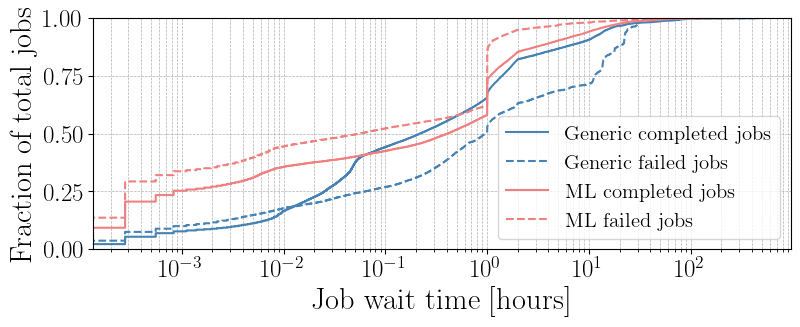

In [19]:
# job wait time cdf

fig, ax = plt.subplots()
# fig size (9,6)
fig.set_size_inches(9, 3)
sns.ecdfplot(data=df_slurm_generic_completed['job_waiting_time'], ax=ax, color='steelblue', linestyle = 'solid', label = 'Generic completed jobs')
sns.ecdfplot(data=df_slurm_generic_failed['job_waiting_time'], ax=ax, color='steelblue', linestyle = 'dashed', label = 'Generic failed jobs')
sns.ecdfplot(data=df_slurm_ml_completed['job_waiting_time'], ax=ax, color='lightcoral', linestyle = 'solid', label = 'ML completed jobs')
sns.ecdfplot(data=df_slurm_ml_failed['job_waiting_time'], ax=ax, color='lightcoral', linestyle = 'dashed', label = 'ML failed jobs')

# set grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xscale('log')
# ax.set_xlim([1, 10**2])
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(loc='lower right', fontsize=15)
plt.xlabel('Job wait time [hours]', fontsize=22)
plt.ylabel('Fraction of total jobs', fontsize=22)
# plt.title('CDF of Number of Cores for Different States and Generic/ML jobs')
plt.savefig('plots/section_5/fig-job_wait_time.pdf', bbox_inches = 'tight')
plt.show()

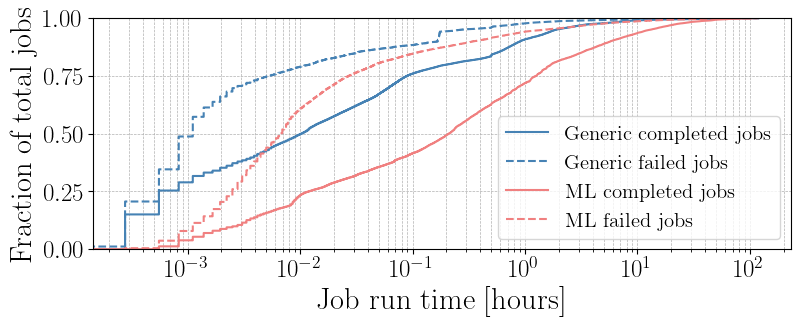

In [20]:
# job wait time cdf

fig, ax = plt.subplots()
# fig size (9,6)
fig.set_size_inches(9, 3)
sns.ecdfplot(data=df_slurm_generic_completed['job_running_time'], ax=ax, color='steelblue', linestyle = 'solid', label = 'Generic completed jobs')
sns.ecdfplot(data=df_slurm_generic_failed['job_running_time'], ax=ax, color='steelblue', linestyle = 'dashed', label = 'Generic failed jobs')
sns.ecdfplot(data=df_slurm_ml_completed['job_running_time'], ax=ax, color='lightcoral', linestyle = 'solid', label = 'ML completed jobs')
sns.ecdfplot(data=df_slurm_ml_failed['job_running_time'], ax=ax, color='lightcoral', linestyle = 'dashed', label = 'ML failed jobs')

# set grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xscale('log')
# ax.set_xlim([1, 10**2])
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(loc='lower right', fontsize=15)
plt.xlabel('Job run time [hours]', fontsize=22)
plt.ylabel('Fraction of total jobs', fontsize=22)
# plt.title('CDF of Number of Cores for Different States and generic/ML jobs')
plt.savefig('plots/section_5/fig-job_run_time.pdf', bbox_inches = 'tight')
plt.show()

In [21]:
# for observed data
# select gpu_node, non-gpu_node, completed, and failed
df_slurm_non_gpu = df_slurm_pd[df_slurm_pd['is_ml'] == 0]
df_slurm_gpu = df_slurm_pd[df_slurm_pd['is_ml'] == 1]
df_slurm_completed = df_slurm_pd[df_slurm_pd['state'] == 'COMPLETED']
df_slurm_failed = df_slurm_pd[df_slurm_pd['state'] == 'FAILED']

df_slurm_non_gpu_completed = df_slurm_non_gpu[df_slurm_non_gpu['state'] == 'COMPLETED']
df_slurm_non_gpu_failed = df_slurm_non_gpu[df_slurm_non_gpu['state'] == 'FAILED']

df_slurm_gpu_completed = df_slurm_gpu[df_slurm_gpu['state'] == 'COMPLETED']
df_slurm_gpu_failed = df_slurm_gpu[df_slurm_gpu['state'] == 'FAILED']


In [22]:
df_slurm_non_gpu['job_waiting_time'].describe(), df_slurm_non_gpu['job_running_time'].describe()

(count    1.406488e+06
 mean     3.770048e+00
 std      1.304778e+01
 min      0.000000e+00
 25%      2.472222e-02
 50%      2.913889e-01
 75%      1.546111e+00
 max      7.921478e+02
 Name: job_waiting_time, dtype: float64,
 count    1.406488e+06
 mean     8.339629e-01
 std      6.070771e+00
 min      0.000000e+00
 25%      5.555556e-04
 50%      6.666667e-03
 75%      8.527778e-02
 max      1.220478e+02
 Name: job_running_time, dtype: float64)

In [23]:
df_slurm_gpu['job_waiting_time'].describe(), df_slurm_gpu['job_running_time'].describe()

(count    190475.000000
 mean          1.773676
 std           7.149398
 min           0.000000
 25%           0.000278
 50%           0.183611
 75%           1.000556
 max         329.370278
 Name: job_waiting_time, dtype: float64,
 count    190475.000000
 mean          2.706094
 std           9.836877
 min           0.000000
 25%           0.007778
 50%           0.108056
 75%           1.005556
 max         121.005556
 Name: job_running_time, dtype: float64)

In [24]:
df_slurm_non_gpu_failed['job_waiting_time'].describe(), df_slurm_gpu_failed['job_waiting_time'].describe()

(count    200983.000000
 mean          6.518943
 std          13.662937
 min           0.000000
 25%           0.063333
 50%           0.958056
 75%          11.347500
 max         429.804444
 Name: job_waiting_time, dtype: float64,
 count    44318.000000
 mean         1.042887
 std          4.786782
 min          0.000000
 25%          0.000278
 50%          0.054722
 75%          1.000278
 max        220.358333
 Name: job_waiting_time, dtype: float64)

In [25]:
df_slurm_non_gpu_failed['job_running_time'].describe(), df_slurm_gpu_failed['job_running_time'].describe()

(count    200983.000000
 mean          0.278374
 std           3.443835
 min           0.000000
 25%           0.000556
 50%           0.001111
 75%           0.005278
 max         119.835833
 Name: job_running_time, dtype: float64,
 count    44318.000000
 mean         0.596330
 std          4.463312
 min          0.000000
 25%          0.002500
 50%          0.006667
 75%          0.027222
 max        114.615000
 Name: job_running_time, dtype: float64)

Regarding median and average times, ML/GPU-enabled jobs wait shorter and run longer than generic CPU-only jobs.